# QSAR Oral Toxicity Dataset - Lab 6

In [138]:
import ds_functions as ds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, validation_curve
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE
from subprocess import call
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, validation_curve
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score


In [139]:
data: pd.DataFrame = pd.read_csv('datasets/qsar_oral_toxicity_v2.csv')
target = 'IS_TOXIC'
original_data = data.copy()

y: np.ndarray = data.pop(target).values
X: np.ndarray = data.values
labels = pd.unique(y)

#### \[No Normalization Needed]

### Balancing

In [140]:
data_unbalanced = original_data.copy()

target_count = original_data[target].value_counts()
min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

RANDOM_STATE = 42
values = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}

df_class_min = original_data[original_data[target] == min_class]
df_class_max = original_data[original_data[target] != min_class]

df_under = df_class_max.sample(len(df_class_min))
values['UnderSample'] = [target_count.values[ind_min_class], len(df_under)]
df_over = df_class_min.sample(len(df_class_max), replace=True)
values['OverSample'] = [len(df_over), target_count.values[1-ind_min_class]]
smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
y = original_data.pop(target).values
X = original_data.values
smote_X, smote_y = smote.fit_sample(X, y)
smote_target_count = pd.Series(smote_y).value_counts()
values['SMOTE'] = [smote_target_count.values[ind_min_class], smote_target_count.values[1-ind_min_class]]

over_sampled = pd.concat([df_over,df_class_max])
under_sampled = pd.concat([df_under,df_class_min])

## Over Sampled Classification

In [141]:
def gradient_boosting(X, y):
    print('{', len(X), ',', len(y), '}')
    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

    n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
    max_depths = [5, 10, 25]
    learning_rate = [.1, .3, .5, .7, .9]
    best = ('', 0, 0)
    last_best = 0
    best_tree = None

    cols = len(max_depths)
    plt.figure()
    fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
    for k in range(len(max_depths)):
        d = max_depths[k]
        values = {}
        for lr in learning_rate:
            yvalues = []
            for n in n_estimators:
                gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
                gb.fit(trnX, trnY)
                prdY = gb.predict(tstX)
                yvalues.append(metrics.accuracy_score(tstY, prdY))
                if yvalues[-1] > last_best:
                    best = (d, lr, n)
                    last_best = yvalues[-1]
                    best_tree = gb
            values[lr] = yvalues
        ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Gradient Boorsting with max_depth=%d'%d,
                            xlabel='nr estimators', ylabel='accuracy', percentage=True)

    plt.show()
    print('Best results with depth=%d, learning rate=%1.2f and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

    prd_trn = best_tree.predict(trnX)
    prd_tst = best_tree.predict(tstX)
    ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

#### Unbalanced Classification

In [142]:
y: np.ndarray = data_unbalanced.pop(target).values
X: np.ndarray = data_unbalanced.values
labels = pd.unique(y)
#gradient_boosting(X, y)

#### Over Sampled Classification

In [137]:
y: np.ndarray = over_sampled.pop(target).values
X: np.ndarray = over_sampled.values
labels: np.ndarray = pd.unique(y)
#gradient_boosting(X, y)

#### Under Sampled Classification

In [67]:
y: np.ndarray = under_sampled.pop(target).values
X: np.ndarray = under_sampled.values
labels: np.ndarray = pd.unique(y)
#gradient_boosting(X, y)

#### SMOTE classification

In [9]:
y = smote_y
X = smote_X
labels = pd.unique(y)
#gradient_boosting(X, y)

<h1 style="color:blue">Logistic Regression </h1>

In [68]:
precison_list = []
recall_list = []
f1_list = []
mcc_list = []

def logistic_regression_kfold(X,y,num_splits_kfold, stratified=True):
#     orig_data = data_df.copy()
#     y: np.ndarray = orig_data.pop('DEATH_EVENT').values
#     X: np.ndarray = orig_data.values
    labels = pd.unique(y)
    
    
    
    if stratified:
        cv = StratifiedKFold(n_splits=num_splits_kfold, random_state=50,shuffle=False)
        cv_split = cv.split(X, y)
    else:
        cv = KFold(n_splits=num_splits_kfold, random_state=50,shuffle=False)
        cv_split = cv.split(X)
        

    for train_index, test_index in cv_split:
        trnX, tstX = X[train_index], X[test_index]
        trnY, tstY = y[train_index], y[test_index]
        
        clf = LogisticRegression(random_state=0 , solver ='lbfgs', max_iter = 1250)
        model = clf.fit(trnX, trnY)

        # print(model.intercept_)
        # print(model.coef_)
        # model.score(X_train, y_train)

        predictions = model.predict(tstX)
        precison = round(precision_score(tstY,predictions),3)
        recall = round(recall_score(tstY,predictions),3)
        f1 = round(f1_score(tstY,predictions),3)
        mcc = round(matthews_corrcoef(tstY,predictions),3)
        
        precison_list.append(precison)
        recall_list.append(recall)
        f1_list.append(f1)
        mcc_list.append(mcc)
        
        print(f'\nPrecision: {precison}')
        print(f'\nRecall: {recall}')
        print(f'\nF1 Score: {f1}')
        print(f'\nMCC: {mcc}\n')
        
#     # Data
#     df=pd.DataFrame({'y2': precison_list, 'y3': f1_list })

#     # multiple line plot
#     plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=2)
#     lt.plot( 'x', 'y3', data=df, marker='', color='orange', linewidth=2)
#     plt.legend()
        
    print(len(precison_list))

    folds = range(1,6)
    
    plt.plot(folds, precison_list, label='Precision')
    plt.plot(folds, recall_list, label='Recall')
    plt.plot(folds, f1_list, label='F1 Score')
    plt.plot(folds, mcc_list, label='MCC')
    plt.legend()
    plt.title('Rate Vs Folds')
    plt.xlabel('Folds')
    plt.ylabel('Rate')
    plt.show()


In [90]:
print(type(y))

y_binary = [] 
for ele in y:
    if ele == 'negative':
        y_binary.append(0)
    else:
        y_binary.append(1)

y_binary = np.asarray(y_binary)
type(y_binary)

<class 'numpy.ndarray'>


numpy.ndarray

In [91]:
def Average(lst): 
    return sum(lst) / len(lst)

def plot_metrics():
    max_array = [max(precison_list),max(recall_list),max(f1_list),max(mcc_list)]
    mean_array = [Average(precison_list),Average(recall_list),Average(f1_list),Average(mcc_list)]
    append_list = mean_array + max_array

    print(max_array)
    print(mean_array)

    #create toy dataframe
    df = pd.DataFrame({"Legend": ["Precision","Recall","F1 Score","MCC","Precision","Recall","F1 Score","MCC"], "clm2": np.asarray(append_list), "Max/Mean": ["Mean", "Mean", "Mean", "Mean", "Max", "Max", "Max", "Max"]})
    #rearrange dataframe and plot
    df.pivot(index = "Max/Mean", columns = "Legend", values = "clm2").plot.bar(edgecolor = "white")
    plt.xticks(rotation = 0)
    plt.show()
    

## Unbalanced Classification


Precision: 0.554

Recall: 0.311

F1 Score: 0.398

MCC: 0.378


Precision: 0.466

Recall: 0.416

F1 Score: 0.44

MCC: 0.393


Precision: 0.541

Recall: 0.358

F1 Score: 0.431

MCC: 0.401


Precision: 0.579

Recall: 0.446

F1 Score: 0.504

MCC: 0.47


Precision: 0.596

Recall: 0.399

F1 Score: 0.478

MCC: 0.451

5


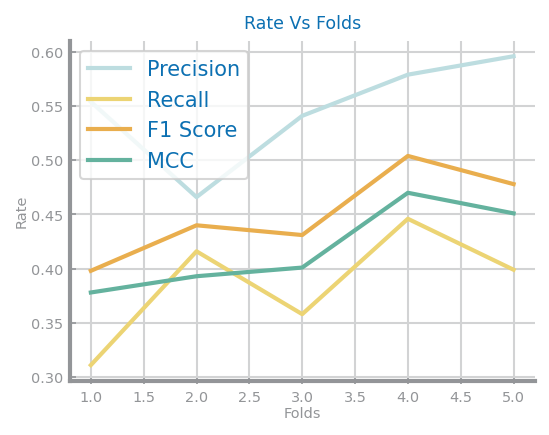

In [28]:
logistic_regression_kfold(X,y_binary,num_splits_kfold=5, stratified=True)

[0.596, 0.446, 0.504, 0.47]
[0.5471999999999999, 0.386, 0.45020000000000004, 0.41859999999999997]


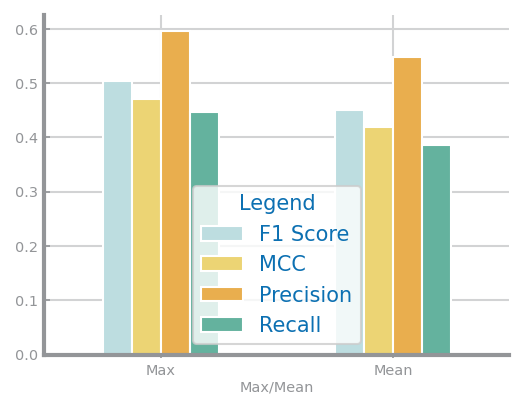

In [29]:
plot_metrics()

## Over Sampled Classification


Precision: 0.899

Recall: 0.973

F1 Score: 0.935

MCC: 0.867


Precision: 0.871

Recall: 0.974

F1 Score: 0.92

MCC: 0.836


Precision: 0.883

Recall: 0.978

F1 Score: 0.928

MCC: 0.854


Precision: 0.898

Recall: 0.977

F1 Score: 0.936

MCC: 0.869


Precision: 0.897

Recall: 0.975

F1 Score: 0.934

MCC: 0.866

5


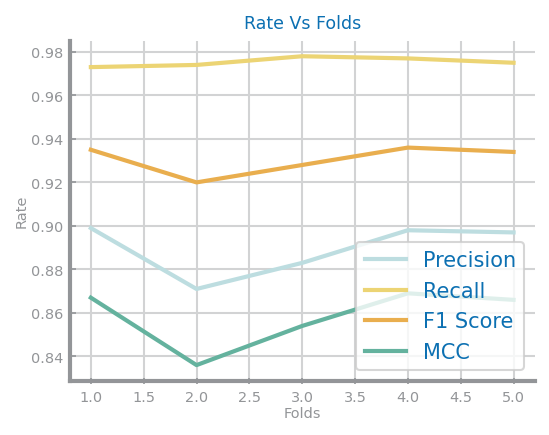

In [34]:
logistic_regression_kfold(X,y_binary,num_splits_kfold=5, stratified=True)

[0.899, 0.978, 0.936, 0.869]
[0.8896000000000001, 0.9753999999999999, 0.9305999999999999, 0.8583999999999999]


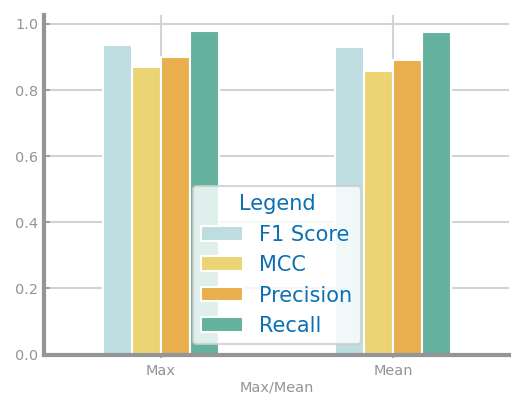

In [35]:
plot_metrics()

## Under Sampled Classification


Precision: 0.734

Recall: 0.635

F1 Score: 0.681

MCC: 0.411


Precision: 0.786

Recall: 0.812

F1 Score: 0.799

MCC: 0.59


Precision: 0.769

Recall: 0.764

F1 Score: 0.766

MCC: 0.534


Precision: 0.736

Recall: 0.696

F1 Score: 0.715

MCC: 0.447


Precision: 0.728

Recall: 0.777

F1 Score: 0.752

MCC: 0.488

5


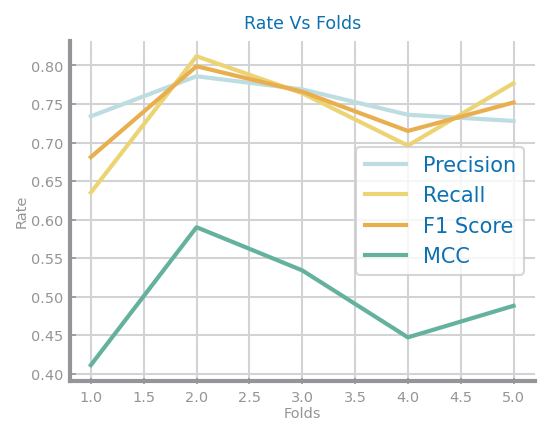

In [40]:
logistic_regression_kfold(X,y_binary,num_splits_kfold=5, stratified=True)

[0.786, 0.812, 0.799, 0.59]
[0.7506, 0.7368, 0.7426, 0.49399999999999994]


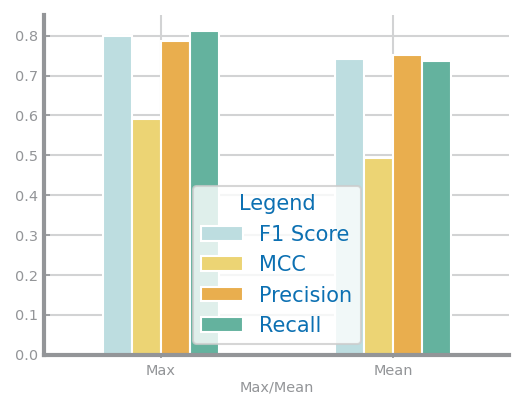

In [41]:
plot_metrics()